### This Google Colab notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# AI reading meters

## Resources

- **Ultralytics YOLOv11 🚀 for object detection, instance segmentation and image classification.**
- PaddleOCR

## Context

As a provider of drinking water to millions of consumers, SUEZ needs to know the exact volume consumed by each client (ie the index of his meter). A modern solution to this problem is telemetering whereby the meter transmits automatically the daily index to our servers. This is already deployed to millions of meters, but there are still some contracts where our operators have to visit the meters once a year, sometimes more. This often involves arranging a meeting with the client when the meters are on private property, which can prove difficult (think about secondary housing) The goal of this challenge is to simplify the process by allowing the client to do the reading himself if it is more convenient: She could just take a picture of the meter, upload it to our servers whereupon a Machine Learning algorithm would validate it and read the digits to get the index.

Prototypes of this projects already exist but require the client to send the picture through email to our service center, which will analyze it and reply several hours later, making any feedback on the picture quality very difficult.

For this challenge, we'll assume that every image represents a meter with an index that can be read by a human.

The goal of this challenge is to design an algorithm reading the consumption index from a valid picture of a meter.

See https://challengedata.ens.fr/challenges/30

## Preliminary remarks

The challenge requires an approach designed specifically for reading single-dial meters, which are also known as gauges. Given the dataset, there might be model degradation in the long term due to the change of generations dial meters in the future. That will require new manual annotations of dial meters and training of preprocessed images.

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.



In [ ]:
!nvidia-smi

Tue Oct 15 17:27:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Google Colab mounting

In [ ]:
# Google mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppose the pictures and test folder are in Challenge_Suez
PATH = "/content/drive/MyDrive"
CHALLENGE_NAME = "/AI-meter-reading"
PATH_PROJECT = PATH + CHALLENGE_NAME
%cd {PATH_PROJECT}

/content/drive/MyDrive/AI-meter-reading


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
from pathlib import Path

# HOME = os.getcwd()
HOME = Path.cwd() # PATH object
print(HOME)

/content/drive/MyDrive/AI-meter-reading


We use ultralytics YOLO and roboflow to annotate image. VoTT from Microsoft can be an alternative in order to annotate the images with bounding boxes.

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.2/112.6 GB disk)


In [ ]:
import torch
import pandas as pd

For the notebook to run without errors, we proceed with the following import.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## YOLOv11

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

We use YOLOv11 in order to detect bounding boxes of meters and liters. Although we only want to retrieve meter values, the detection of liters adds to the confidence of the model in detecting meters. Hence we value both metrics for the class of meters and simultaneously meters and liters. The computation of precision and recall is with respect to class 1 (meters). As we know there is exactly one meter per image, good recall and precision are not meaninful. The essential part of the object detection is the position of the dials.

### Metrics

The usual metrics in object detection are:
- Average Precision (AP): AP computes the area under the precision-recall curve, providing a single value that encapsulates the model's precision and recall performance.
- mAP Mean Average Precision (mAP): mAP extends the concept of AP by calculating the average AP values across multiple object classes. This is useful in multi-class object detection scenarios to provide a comprehensive evaluation of the model's performance.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

We rather use IoU (Intersection over union): IoU is a measure that quantifies the overlap between a predicted bounding box and a ground truth bounding box. **It plays a fundamental role in evaluating the accuracy of object localization.** We do it for class 1 and simultaneously for classes 0 and 1. This corresponds to the loss parameter `box`. We do not tune the weight of distributed focal loss as there is not imbalance in our context. We many need to increase `box`.

In the following, we do not have imbalance of classes, hence we may zero the weight of the distribution focal loss.


## Custom preprocessing

We automate this manual preprocessing, optimization based on the dataset of 104 images with bounding boxes (one for meters, one for liters per image). The default size handled by YOLO is `imagesz = 640` ($640 \times 640$). Because the dataset contains images of various sizes, we let YOLO handled it internally.

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them. YOLO is used for preprocessing as a semi-supervised method for cropping around the meter boards.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YPr8z8exI5EnxDegn87q") # available until late October
project = rf.workspace("ai-meter-reading").project("ai-meter-reading")
version = project.version(1)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘/content/drive/MyDrive/AI-meter-reading/datasets’: File exists
/content/drive/MyDrive/AI-meter-reading/datasets
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# # Example dictionary of YOLO parameters
# yolo_params = {
#     'batch_size': 16,
#     'learning_rate': 0.001,
#     'momentum': 0.9,
#     'weight_decay': 0.0005,
#     'img_size': 640,
#     'epochs': 50,
#     'num_classes': 80,
#     'anchors': [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]],
#     'iou_threshold': 0.5,
#     'conf_threshold': 0.5,
#     'nms_threshold': 0.4,
#     'augmentation': {
#         'flip': True,
#         'scale': 0.5,
#         'mosaic': True
#     }
# }
yolo_loss_params = {
    'box': 7.5, # Specifies the importance of the bounding box coordinates in the predicted boxes
    'cls': 0.5, # Classification loss in the total loss function
    'dfl': 1.5  # Weight of distribution focal loss (dfl).
}

yolo_misc_params = {
    'pretrained': True,
    'single_cls': True,
    'rect': False,
    'close_mosaic': 10,
    'fraction': 1.0,
    'freeze': None
}

In [ ]:
%cd {HOME}

/content/drive/MyDrive/AI-meter-reading


In [ ]:
# Load a COCO-pretrained YOLO11n model
# model = ultralytics.YOLO("yolo11n.pt")

# # automatic hyperparameter tuning using mutation algorithm (learning rate, weight decay)
# model.tune(data=f"{dataset.location}/data.yaml", epochs=30, iterations=300, optimizer="AdamW", imgsz=640, plots=False, save=False, val=False)
# device = 'cuda' if torch.cuda.is_available() else 'cpu' (automatic in new version if cuda is available)
# Train the model on the COCO8 example dataset for 40 epochs
# model.train(data=f"{dataset.location}/data.yaml", epochs=50)
# model.train(data=f"{dataset.location}/data.yaml", epochs=100)
# model.tune(data=f"{dataset.location}/data.yaml", epochs=20, iterations=5, optimizer="AdamW", imgsz=640, plots=False, save=False, val=False)


Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 1/5 iterations complete ✅ (102.78s)
Tuner: Results saved to runs/detect/tune
Tuner: Best fitness=0.20242 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.37016, 'metrics/recall(B)': 0.35714, 'metrics/mAP50(B)': 0.32027, 'metrics/mAP50-95(B)': 0.18932, 'val/box_loss': 1.68676, 'val/cls_loss': 2.6

In [ ]:
# Load a COCO-pretrained YOLO11n model
model = ultralytics.YOLO("yolo11n.pt")

In [ ]:
model.train(data=f"{dataset.location}/data.yaml", epochs=100)

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/AI-meter-reading/datasets/ai-meter-reading-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /content/drive/MyDrive/AI-meter-reading/datasets/ai-meter-reading-1/train/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/AI-meter-reading/datasets/ai-meter-reading-1/valid/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.48G      2.289      4.462      1.885         32        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         21         42   0.000409     0.0714   0.000238   4.61e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.42G      2.088       4.23      1.668         28        640: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         21         42    0.00216      0.333    0.00793    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.4G      1.785      3.635       1.26         31        640: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         21         42    0.00495      0.643      0.043    0.00991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.4G      1.642       2.94      1.215         39        640: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         42    0.00643      0.786      0.159     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.41G      1.644      2.625      1.214         29        640: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         21         42     0.0062       0.81      0.259      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.4G      1.622       2.35      1.214         35        640: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         21         42    0.00635      0.905      0.341      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G      1.579      2.132      1.228         22        640: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         21         42    0.00548       0.81      0.338      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.4G      1.552      1.856      1.203         29        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         21         42    0.00495      0.714      0.305      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.41G      1.584      1.932      1.246         36        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         21         42    0.00513      0.762      0.407       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.4G      1.477      1.767      1.202         27        640: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         21         42    0.00512      0.762      0.438      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.4G      1.441      1.663      1.157         41        640: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         21         42    0.00526      0.786      0.543       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.41G      1.372      1.654      1.149         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         21         42      0.576      0.548      0.509      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.41G        1.5       1.67       1.18         40        640: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         42          1     0.0602      0.547      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.4G      1.425      1.589      1.147         41        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         21         42          1      0.142      0.552      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.41G      1.456      1.637      1.207         30        640: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         21         42          1      0.216      0.648      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.41G      1.371      1.447      1.164         39        640: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         21         42      0.918      0.251      0.647      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.4G      1.479      1.571      1.218         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         21         42      0.702      0.324      0.618      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.41G      1.314      1.363       1.13         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         21         42      0.758      0.453      0.663      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.41G      1.323      1.457      1.122         35        640: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         21         42      0.812      0.366      0.665      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.41G      1.337      1.459      1.148         35        640: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         21         42      0.759      0.524      0.673       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.4G      1.322      1.378      1.129         34        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         42      0.863      0.585      0.769      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.41G      1.289      1.341      1.156         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         21         42      0.802      0.704      0.824      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.41G      1.271      1.299      1.121         34        640: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         21         42      0.836        0.7      0.862       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.41G      1.336      1.311       1.11         41        640: 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         21         42      0.805      0.786      0.831      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.4G      1.291      1.284      1.108         30        640: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         42      0.831      0.799      0.849      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.41G      1.279      1.235      1.101         30        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         21         42      0.937      0.751      0.874      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G      1.287      1.199      1.116         33        640: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         21         42      0.972      0.779       0.86      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.41G      1.357      1.292      1.112         23        640: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         21         42      0.866      0.714      0.866      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.4G      1.234      1.225      1.068         38        640: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         21         42      0.872      0.738      0.879      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.41G      1.295      1.178      1.095         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         21         42      0.956      0.754      0.877      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.41G      1.255      1.216      1.126         28        640: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         21         42      0.979      0.793      0.882      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.41G      1.199      1.123      1.065         25        640: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         21         42       0.85      0.824      0.882      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.4G      1.205      1.154      1.083         26        640: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         21         42      0.875      0.764      0.876      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.41G      1.197      1.142      1.089         31        640: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         21         42      0.932      0.738      0.853      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.41G      1.218      1.124      1.059         25        640: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         21         42      0.824      0.857       0.88      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.41G      1.145      1.158      1.046         32        640: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         21         42      0.954      0.811      0.869       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.4G       1.21      1.054      1.053         36        640: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         21         42      0.839       0.81      0.853      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.41G      1.179      1.104      1.041         49        640: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         21         42      0.871      0.762       0.87      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.41G      1.118      1.058      1.003         33        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         21         42      0.959      0.764       0.88       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.41G      1.117      1.076      1.024         32        640: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         21         42       0.92      0.806      0.897      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.4G      1.124      1.013       1.05         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         21         42      0.913      0.769      0.897      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.41G       1.06      1.018      1.021         27        640: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         21         42      0.929      0.727      0.907      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.41G      1.166      1.042      1.065         34        640: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         21         42      0.899      0.733      0.911      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.41G      1.135      1.066       1.09         33        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         21         42      0.891      0.833      0.909      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.4G      1.107      1.056      1.068         20        640: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         42      0.903      0.833      0.914      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.41G      1.063     0.9605      1.012         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         21         42      0.983      0.833      0.867      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.41G      1.025      1.005     0.9915         46        640: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         21         42      0.934      0.834      0.859      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.41G      1.018     0.9226      1.005         28        640: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         21         42      0.897      0.827      0.891      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.4G      1.069     0.9901     0.9962         28        640: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         21         42      0.957       0.81      0.886      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.41G      1.022     0.9148      0.998         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         42      0.934      0.857      0.886      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.41G      1.032     0.8893     0.9815         36        640: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         21         42       0.93      0.843      0.892      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.41G      1.028     0.9259      1.001         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         21         42      0.883      0.868       0.92      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.4G       0.95     0.8594      1.006         25        640: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         21         42      0.975       0.83      0.929      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.41G     0.9998     0.9338      1.015         26        640: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         21         42      0.956      0.881      0.937      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.41G     0.9548       0.93      1.003         36        640: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         21         42      0.981       0.81       0.93      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.41G      0.979     0.8337     0.9625         31        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         21         42      0.979      0.795      0.927      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.4G     0.9537     0.8281     0.9413         29        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         21         42      0.858      0.905      0.934      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.41G     0.9839     0.8949     0.9957         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         21         42      0.926      0.874      0.929      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.41G     0.9873     0.8294     0.9948         34        640: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         21         42      0.923      0.877      0.925      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.41G     0.9387     0.8241     0.9685         26        640: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         21         42      0.914      0.857      0.917      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.4G     0.9614     0.8524     0.9572         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         21         42      0.925      0.857       0.92       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.41G     0.9451     0.8317     0.9583         36        640: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         21         42      0.856      0.896      0.925      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.41G     0.9314     0.8427      0.962         23        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         21         42      0.879      0.919      0.931      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.41G     0.8568     0.7876     0.9369         29        640: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         21         42      0.916      0.923      0.936      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.4G     0.8852     0.8241      0.948         25        640: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         21         42      0.939      0.903      0.938      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.41G     0.9605     0.8251     0.9632         46        640: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         21         42      0.993      0.881      0.944      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.41G     0.8742     0.7682     0.9516         29        640: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         21         42      0.971        0.9      0.947       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.41G     0.8529      0.783     0.9478         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         42      0.983      0.881      0.942      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.4G      0.864     0.8074     0.9504         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         21         42      0.913      0.943      0.948      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.41G     0.8153     0.7244     0.9232         34        640: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         21         42      0.973        0.9      0.952      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.41G     0.8286     0.7279     0.9129         39        640: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         21         42      0.981      0.905      0.952      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.41G     0.8342      0.717     0.9125         27        640: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         21         42      0.993      0.925      0.953      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G     0.8544      0.773     0.9468         29        640: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         21         42      0.943      0.912      0.932      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.41G     0.7722     0.7449     0.9328         28        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         21         42       0.94      0.895      0.926      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.41G     0.7884     0.6978      0.904         22        640: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         21         42      0.993      0.839      0.925      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.41G     0.8399     0.7063      0.909         35        640: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         21         42      0.921      0.911      0.929      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.4G     0.8022      0.777     0.9263         23        640: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         21         42      0.974      0.882      0.934      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.41G     0.7463     0.6732     0.8937         25        640: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         21         42      0.959        0.9      0.936      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.41G     0.8131     0.6958     0.8878         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         21         42      0.944      0.928      0.939      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.41G      0.788     0.6738     0.9124         32        640: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         42      0.974      0.913      0.937      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.7448     0.6791     0.8881         39        640: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         42      0.974      0.917      0.937      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.41G     0.7854      0.682      0.919         29        640: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         21         42      0.939      0.929      0.934       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.41G     0.7712     0.6698      0.898         45        640: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         21         42      0.974      0.908      0.933      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.41G     0.7378     0.6779     0.9085         23        640: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

                   all         21         42      0.929      0.919       0.93      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.4G     0.7493     0.6864     0.9131         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         21         42      0.938      0.929       0.93      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.41G      0.758     0.6632     0.9132         30        640: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         21         42      0.938      0.929      0.929      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.41G     0.7275     0.6664     0.9035         40        640: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         42       0.97      0.922      0.928      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.41G     0.7295     0.6688     0.9014         32        640: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         21         42      0.956       0.92      0.929      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.4G     0.6618     0.6694     0.8773         14        640: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         21         42      0.955      0.922      0.929      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.41G     0.7207     0.6563     0.9165         26        640: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         21         42      0.955      0.921       0.93      0.559


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.39G     0.6842     0.7156     0.8521         18        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         21         42      0.955      0.918      0.929      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.39G     0.7047      0.736     0.8924         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         21         42      0.967      0.914      0.938      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.38G     0.6745     0.6855     0.8653         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         21         42      0.983      0.901      0.944       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.39G     0.6568     0.6632     0.8555         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         21         42      0.957      0.924      0.944      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.39G     0.6686     0.6757     0.8606         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         21         42      0.973      0.898      0.943      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.39G     0.6718     0.6915     0.8663         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         21         42      0.962      0.905      0.939       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.38G     0.6791     0.7057     0.8698         18        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         21         42      0.963      0.905      0.939      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.39G     0.6309     0.6853     0.8715         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         21         42      0.964      0.903      0.938      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.39G     0.6548     0.6673      0.856         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         21         42      0.963      0.904      0.937      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.39G     0.6464     0.6876     0.8649         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         21         42      0.965      0.905      0.938      0.563



100 epochs completed in 0.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


                   all         21         42      0.971        0.9      0.947      0.578
                liters         21         21          1      0.847      0.939      0.547
                meters         21         21      0.941      0.952      0.955      0.609
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d46923e3bb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/ # print all the results and prove that the weights are here in the format pt

args.yaml					   P_curve.png	     train_batch2.jpg
confusion_matrix_normalized.png			   PR_curve.png      train_batch450.jpg
confusion_matrix.png				   R_curve.png	     train_batch451.jpg
events.out.tfevents.1729014130.f49ce6aae9a4.342.1  results.csv	     train_batch452.jpg
F1_curve.png					   results.png	     val_batch0_labels.jpg
labels_correlogram.jpg				   train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					   train_batch1.jpg  weights


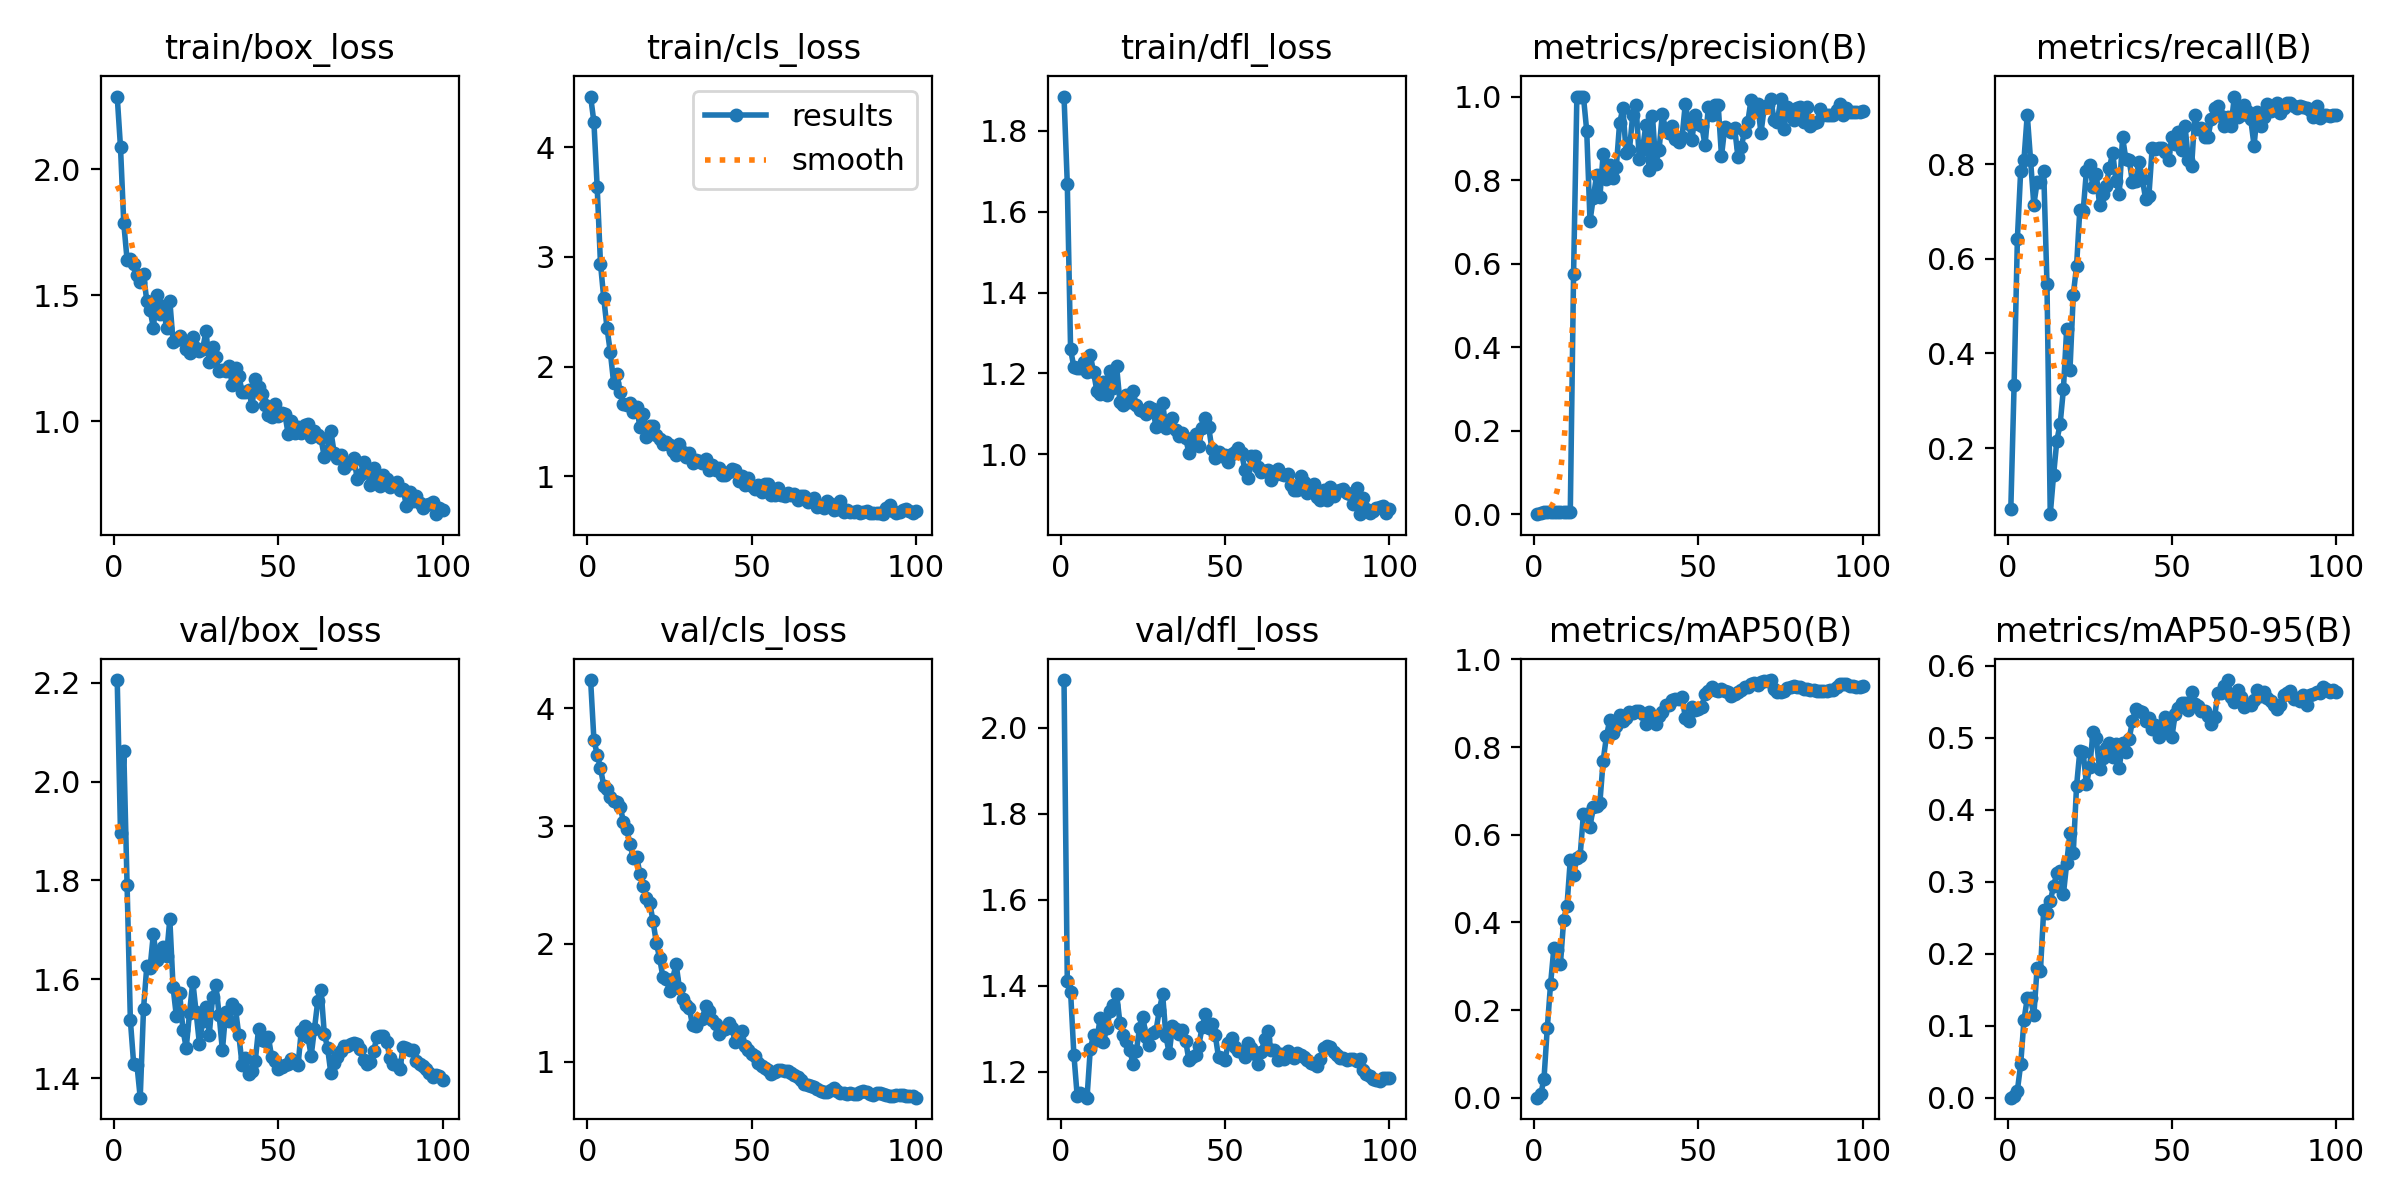

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

### Validation of the model

In [ ]:
metrics = model.val()
metrics.results_dict

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/AI-meter-reading/datasets/ai-meter-reading-1/valid/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all         21         42      0.972        0.9      0.947      0.569
                liters         21         21          1      0.847      0.939      0.535
                meters         21         21      0.945      0.952      0.955      0.602
Speed: 0.4ms preprocess, 18.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2


{'metrics/precision(B)': 0.9723705685877451,
 'metrics/recall(B)': 0.8995884375946575,
 'metrics/mAP50(B)': 0.9469881006093457,
 'metrics/mAP50-95(B)': 0.5685241166485087,
 'fitness': 0.6063705150445924}

In [ ]:
# Load the model
model = ultralytics.YOLO(PATH_PROJECT + '/runs/detect/train/weights/best.pt')
FOLDER_IMAGE_PATH = PATH_PROJECT + '/pictures'

In [ ]:
results = model.predict(source=FOLDER_IMAGE_PATH,  project='pictures_annotated', stream=True) # generator in order to avoid memory leak

In [ ]:
from ultralytics.utils.plotting import save_one_box
# found in ultralytics/engine/results.py
# We use composition to include Results instances within the ResultMeters class instead of inheriting
from PIL import Image, ImageDraw, ImageFont
from ultralytics.utils import IS_COLAB, IS_KAGGLE, LOGGER, TryExcept, ops
from ultralytics.utils.files import increment_path



class ResultMeters():
    """
    A class for storing and manipulating inference results containing dial meters.

    This class encapsulates among other the functionality for handling dial meters
    and classification results from YOLO models. it is a composition with the original
    results class in the package ultralytics.

    Attributes:
        result (ultralytics.engine.Results): A result containing the bounding boxes and associated probabilities for classification tasks.
        detection_precision (int): A flag indicating the degree of certainty of the position of bounding boxes.
        filename (str): Path to the image file.

    Methods:
        save_meters_crop(save_dir, file_name=None): Saves cropped detection (containing meters) images to specified directory (one per dial) following some criterion.
        set_detection_precision(flag=0): Set the precision of the detection from the scale from -1 to 1 (no, maybe, sure).
        set_filename(file_name): Set the filename of the image.
        show: Shows annotated results on screen.
    """
    def __init__(self, result):
        """
        Result for
        """
        self.result = result
        self.detection_precision = None
        self.filename = None


    def save_meters_crop(self, save_dir, file_name=None):
        """
        Saves cropped detection (containing meters) images to specified directory (one per dial) following some criterion.

        This method saves cropped images of detected objects to a specified directory. Each crop is saved in a
        subdirectory named after the object's class, with the filename based on the input file_name.

        Args:
            save_dir (str | Path): Directory path where cropped images will be saved (flag -1, 0 or 1)
            file_name (str | Path): Base filename for the saved cropped images. Default is Path("im.jpg").

        Notes:
            - This method does not support Classify or Oriented Bounding Box (OBB) tasks.
            - Crops are saved as 'save_dir/class_name/file_name.jpg'.
            - The method will create necessary subdirectories if they don't exist.
            - Original image is copied before cropping to avoid modifying the original.
        """
        cropped = False
        if self.result.probs is not None:
            ultralytics.utils.LOGGER.warning("WARNING ⚠️ Classify task do not support `save_crop`.")
            return
        if self.result.obb is not None:
            ultralytics.utils.LOGGER.warning("WARNING ⚠️ OBB task do not support `save_crop`.")
            return
        if file_name is None:
            file_name = Path(self.result.path).stem
        # It is ensured that the boxes are not empty!
        max_conf = 0
        # min_conf = float('inf')
        box1_max_conf = None # only class meters
        # box0_min_conf = None
        cnt_liters = 0
        for d in self.result.boxes:
            confidence = d.conf
            if int(d.cls) == 1 and confidence > max_conf:
                max_conf = confidence
                box1_max_conf = d
            # elif int(d.cls) == 0 and confidence < min_conf:
            #     min_conf = confidence
            #     box0_min_conf = d
            #     cnt_liters += 1

        if box1_max_conf is not None:
            cropped = True
            self.set_detection_precision(1)
            crop = save_one_box(
                box1_max_conf.xyxy,
                self.result.orig_img.copy(),
                file=Path(save_dir)  / f"{Path(file_name)}-res.jpg",
                BGR=True,
            )
        # elif cnt_liters == 2:
        #     cropped = True
        #     self.set_detection_precision(0)
        #     crop = save_one_box(
        #         box0_min_conf.xyxy,
        #         self.result.orig_img.copy(),
        #         file=Path(save_dir)  / f"{Path(file_name)}-cropped_around_liters.jpg",
        #         BGR=True,
        #     )
        else:
            self.set_detection_precision(-1)
            file = Path(save_dir) / f"{Path(file_name)}-res.jpg"
            file.parent.mkdir(parents=True, exist_ok=True)  # make directory
            Image.fromarray(self.result.orig_img.copy()).save(file, quality=95, subsampling=0)  # save RGB
            # self.result.save(filename=Path(save_dir) / f"{Path(file_name)}_no_cropped.jpg")
            ultralytics.utils.LOGGER.warning("WARNING ⚠️ No meters detected.")
        self.set_filename(file_name)
        return cropped


    def set_detection_precision(self, flag=0):
        """
        Set the precision of the detection from the scale from -1 to 1 (no, maybe, sure)
        """
        self.detection_precision = flag

    def set_filename(self, file_name):
        """
        Set the filename of the image
        """
        self.filename = file_name

    def show(self, result):
        """
        Use the show method of Result class to show the resulting annotated image
        """
        self.result.show()


Count of pictures to get the efficiency

In [ ]:
count_pictures = 0
count_cropped = 0
dict_flags = {'ID': [], 'Flag': []}
# write a file YOLO_index_confidence
for result in results:
    # result.to_csv(path_or_buf=PATH_PROJECT + '/results_out.csv', mode='a')
    r = ResultMeters(result)
    cropped = r.save_meters_crop(save_dir=PATH_PROJECT + '/pictures_cropped')
    dict_flags['ID'].append(r.filename.split('.')[0])
    dict_flags['Flag'].append(str(r.detection_precision))
    if cropped:
        count_cropped += 1
    count_pictures += 1
print(f"Number of cropped pictures: {count_cropped} / {count_pictures} = {(count_cropped / count_pictures): 10.2f}")
pd.DataFrame(dict_flags).to_csv(PATH_PROJECT + '/YOLO_index_confidence.csv')


image 1/793 /content/drive/MyDrive/AI-meter-reading/pictures/0127d0.jpg: 320x640 1 liters, 51.1ms
WARNING ⚠️ No meters detected.
image 2/793 /content/drive/MyDrive/AI-meter-reading/pictures/012e2f.jpg: 480x640 1 liters, 1 meters, 51.0ms
image 3/793 /content/drive/MyDrive/AI-meter-reading/pictures/01a650.jpg: 384x640 1 liters, 1 meters, 54.1ms
image 4/793 /content/drive/MyDrive/AI-meter-reading/pictures/0249c2.jpg: 480x640 1 liters, 1 meters, 13.4ms
image 5/793 /content/drive/MyDrive/AI-meter-reading/pictures/027912.jpg: 640x480 1 liters, 1 meters, 76.3ms
image 6/793 /content/drive/MyDrive/AI-meter-reading/pictures/0311da.jpg: 480x640 1 liters, 1 meters, 15.5ms
image 7/793 /content/drive/MyDrive/AI-meter-reading/pictures/032a07.jpg: 640x576 1 meters, 60.5ms
image 8/793 /content/drive/MyDrive/AI-meter-reading/pictures/03e8fc.jpg: 480x640 1 liters, 17.3ms
WARNING ⚠️ No meters detected.
image 9/793 /content/drive/MyDrive/AI-meter-reading/pictures/03f766.jpg: 640x480 1 liters, 2 meterss, 1